In [25]:
# ✅ Step 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.loader import NeighborLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

In [26]:
# ✅ Step 3: Load Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(r"C:\Users\akash\OneDrive\Desktop\New folder", transform=transform)  # Change to your dataset path
class_names = dataset.classes  # ← This defines 'class_names'

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

In [27]:
# ✅ Step 2: Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor()
])

In [28]:
from torchvision import models         # Import the module that provides pretrained vision architectures

# 1) Load a ResNet‑18 pretrained on ImageNet
cnn_model = models.resnet18(pretrained=True)

# 2) Freeze all existing layers so their weights won’t be updated during training
for param in cnn_model.parameters():
    param.requires_grad = False

# 3) Replace ResNet’s final classifier head with a small trainable network:
cnn_model.fc = nn.Sequential(
    nn.Linear(                              # • Linear layer mapping from ResNet’s feature size…
        cnn_model.fc.in_features,           #   (automatically grabs whatever “in_features” was)
        256                                 #   down to 256 hidden units
    ),
    nn.ReLU(),                              # • Non‑linear activation to introduce modeling capacity
    nn.Dropout(0.3),                        # • Randomly zero 30% of activations each pass (regularization)
    nn.Linear(                              # • Final linear layer…
        256,                                #   taking those 256 units
        128                                 #   and outputting a 128‑dim feature vector
    )  # This 128‑d output is what you’ll use as your image embedding
)


c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = cnn_model.to(device)


In [30]:
# ✅ Step 5: Feature Extraction

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

def extract_features(model, dataloader):
    features, labels = [], []                    # 1. Prepare empty lists to collect per‑batch feature tensors and labels.
    model.eval()                                 # 2. Switch the model to evaluation mode (disables dropout, batch‑norm updates).
    device = next(model.parameters()).device     # 3. Grab the device (CPU/GPU) where the model’s weights live.
    with torch.no_grad():                        # 4. Disable gradient calculation (speeds up inference & saves memory).
        for imgs, lbls in dataloader:            # 5. Iterate over each batch of images and their labels.
            imgs = imgs.to(device)               # 6. Move images to the same device as the model.
            feats = model(imgs)                  # 7. Run a forward pass to get the feature vectors.
            features.append(feats.cpu())         # 8. Move features back to CPU and store in the list.
            labels.append(lbls.cpu())            # 9. Move labels to CPU and store alongside.
    return torch.cat(features), torch.cat(labels)# 10. Concatenate all batch‑wise tensors into two big tensors.

# 11. Select CUDA if available, otherwise fallback to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 12. Move your CNN feature‑extractor onto that device.
cnn_model = cnn_model.to(device)

# 13. Extract & collect feature vectors and labels for the entire train set.
train_features, train_labels = extract_features(cnn_model, train_loader)

In [31]:
# ✅ Step 6: Graph Construction (Top-K Cosine Similarity)
def build_sparse_graph(features, labels, top_k=5):
    sim_matrix = cosine_similarity(features)
    edges = [ ]

    for i in range(len(sim_matrix)):
        top_k_indices = sim_matrix[i].argsort()[-(top_k + 1):]  # +1 to skip self
        for j in top_k_indices:
            if i != j:
                edges.append([i, j])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=features, edge_index=edge_index, y=labels)

graph_data = build_sparse_graph(train_features, train_labels, top_k=5)
graph_data = graph_data.to(device)

In [32]:
# ✅ Step 7: Define GAT + MLP Model
class GAT_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=2, concat=True)
        self.gat2 = GATConv(hidden_dim * 2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.relu(self.gat2(x, edge_index))
        x = self.bn1(x)
        x = self.dropout(x)
        return self.mlp(x)


In [33]:
"""from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data

def build_sparse_graph(features, labels, top_k=5):
    sim_matrix = cosine_similarity(features)
    edges = []

    for i in range(len(sim_matrix)):
        top_k_indices = sim_matrix[i].argsort()[-(top_k + 1):]  # top K+1 includes self
        for j in top_k_indices:
            if i != j:
                edges.append([i, j])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(x=features, edge_index=edge_index, y=labels)

graph_data = build_sparse_graph(train_features, train_labels, top_k=5)"""

'from sklearn.metrics.pairwise import cosine_similarity\nfrom torch_geometric.data import Data\n\ndef build_sparse_graph(features, labels, top_k=5):\n    sim_matrix = cosine_similarity(features)\n    edges = []\n\n    for i in range(len(sim_matrix)):\n        top_k_indices = sim_matrix[i].argsort()[-(top_k + 1):]  # top K+1 includes self\n        for j in top_k_indices:\n            if i != j:\n                edges.append([i, j])\n\n    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()\n    return Data(x=features, edge_index=edge_index, y=labels)\n\ngraph_data = build_sparse_graph(train_features, train_labels, top_k=5)'

In [34]:
# --- 6) TRAINING LOOP (with in‐loop best‐model save) ---
model = GAT_MLP(128, 128, len(class_names))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
best_loss = float('inf')

EPOCHS       = 20  
best_loss = float('inf')
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    out  = model(graph_data)           # [N_nodes × num_classes]
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {loss.item():.4f}")
            
    # Save the best GAT_MLP so far
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best_gat_model.pt")

# --- 7) FINAL CHECKPOINT SAVE (CNN + GAT + OPTIMIZER) ---
print("Training complete. Saving final checkpoints…")
torch.save(cnn_model.state_dict(), "cnn_feat_extractor.pth")
torch.save(model.state_dict(),     "gat_mlp_classifier.pth")

torch.save({
    'cnn_state_dict': cnn_model.state_dict(),
    'gat_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'epochs_trained': EPOCHS
}, "full_training_checkpoint.pth")

print("Models saved:")
print(" • cnn_feat_extractor.pth")
print(" • gat_mlp_classifier.pth")
print(" • full_training_checkpoint.pth")

Epoch 1/20 — Loss: 2.0044
Epoch 2/20 — Loss: 1.8139
Epoch 3/20 — Loss: 1.6465
Epoch 4/20 — Loss: 1.5272
Epoch 5/20 — Loss: 1.4107
Epoch 6/20 — Loss: 1.3143
Epoch 7/20 — Loss: 1.2212
Epoch 8/20 — Loss: 1.1349
Epoch 9/20 — Loss: 1.0537
Epoch 10/20 — Loss: 0.9928
Epoch 11/20 — Loss: 0.9362
Epoch 12/20 — Loss: 0.8790
Epoch 13/20 — Loss: 0.8351
Epoch 14/20 — Loss: 0.7995
Epoch 15/20 — Loss: 0.7473
Epoch 16/20 — Loss: 0.7094
Epoch 17/20 — Loss: 0.6829
Epoch 18/20 — Loss: 0.6406
Epoch 19/20 — Loss: 0.6094
Epoch 20/20 — Loss: 0.6019
Training complete. Saving final checkpoints…
Models saved:
 • cnn_feat_extractor.pth
 • gat_mlp_classifier.pth
 • full_training_checkpoint.pth


In [35]:
# ✅ Evaluation (after training)
model.eval()
with torch.no_grad():
    preds = model(graph_data).argmax(dim=1)

acc = (preds == graph_data.y).float().mean()
print(f"\n✅ Accuracy: {acc * 100:.2f}%")
print("\n📄 Classification Report:")
print(classification_report(graph_data.y, preds, target_names=class_names))


✅ Accuracy: 83.02%

📄 Classification Report:
                      precision    recall  f1-score   support

     Angular_leafspt       0.90      0.94      0.92       200
      Bloosom_blight       1.00      0.54      0.70        93
           Leaf_spot       0.91      0.94      0.93       296
   anthracnose_fruit       0.33      0.03      0.05        39
           gray_mold       0.66      0.96      0.78       206
powdery_mildew_fruit       0.00      0.00      0.00        63
 powdery_mildew_leaf       0.85      0.95      0.89       263

            accuracy                           0.83      1160
           macro avg       0.66      0.62      0.61      1160
        weighted avg       0.79      0.83      0.79      1160



c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

def predict_leaf_disease(image_path, cnn_model, gnn_model, graph_data, features_db, class_names, threshold=0.5):
    """
    Predict strawberry leaf disease from an image
    """
    cnn_model.eval()
    gnn_model.eval()

    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        feature = cnn_model(img_tensor)  # Get 128-dim feature vector
        # Compare with existing features using cosine similarity
        sim = cosine_similarity(feature, features_db)[0]
        best_match_idx = sim.argmax()
        confidence = sim[best_match_idx]

        # Use the matching node in the GNN to get prediction
        out = gnn_model(graph_data)[best_match_idx]
        probs = F.softmax(out, dim=0)
        pred_idx = torch.argmax(probs).item()

        print(f"\n🖼️ Image: {image_path}")
        print(f"🔍 Predicted Class: {class_names[pred_idx]}")
        print(f"📊 Confidence (cosine similarity): {confidence:.2f}")
        print(f"🔢 Probabilities: {probs.tolist()}")

        if confidence < threshold:
            print("⚠️ Warning: The model is not confident. This image may be unknown or unrelated.")

In [50]:

predict_leaf_disease(r"C:\Users\akash\OneDrive\Desktop\leaf 2 G.jpg", cnn_model, model, graph_data, train_features, class_names) 


🖼️ Image: C:\Users\akash\OneDrive\Desktop\leaf 2 G.jpg
🔍 Predicted Class: gray_mold
📊 Confidence (cosine similarity): 0.87
🔢 Probabilities: [0.10424687713384628, 0.09175518155097961, 0.08490502834320068, 0.14135700464248657, 0.32810136675834656, 0.16408590972423553, 0.08554867655038834]


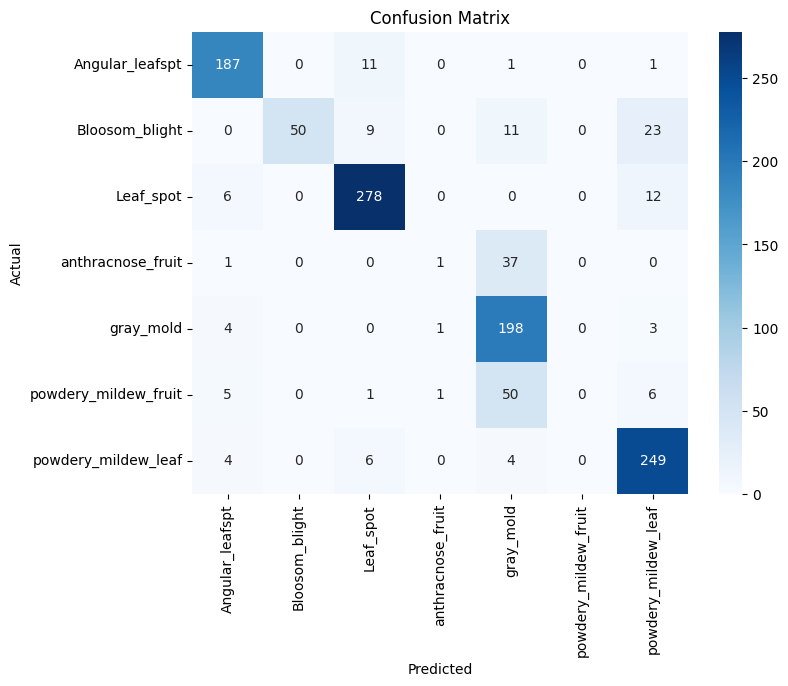

In [51]:
import pandas as pd
cm = confusion_matrix(graph_data.y, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

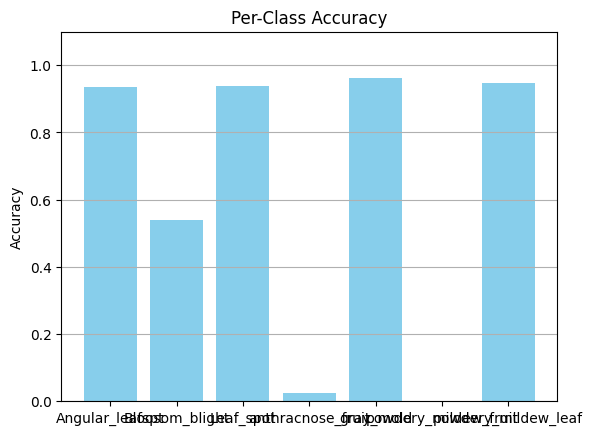

In [52]:
from sklearn.metrics import accuracy_score
import numpy as np

# Calculate per-class accuracy
y_true = graph_data.y.cpu().numpy()
y_pred = preds.cpu().numpy()

per_class_accuracy = []
for i, class_name in enumerate(class_names):
    class_indices = np.where(y_true == i)
    acc = accuracy_score(y_true[class_indices], y_pred[class_indices])
    per_class_accuracy.append(acc)

# Plot
plt.bar(class_names, per_class_accuracy, color='skyblue')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(True, axis='y')
plt.show()
